## Prepare Dataset and Specify Parameters (please only edit cells in this section)

In [1]:
# Parameters to specify

# Specify here at what frame NC14 starts
nc14_start_frame = 164

# Any trace with frame number smaller than min_frames will be filtered out
min_frames = 40

# Number of bins you want to split the full embryo into
num_bins = 42

In [38]:
# Dataset Directory

dataset_folder = '/mnt/Data1/Josh/transcription_pipeline-main/'

RBSPWM_datasets = [
    "test_data/2024-02-26/Halo-RBSPWM_embryo01",
    "test_data/2024-02-26/Halo-RBSPWM_embryo02",
    "test_data/2024-05-07/Halo552-RBSPWM_embryo01",
    "test_data/2024-05-07/Halo552-RBSPWM_embryo02",
    "test_data/2024-05-09/Halo552-RBSPWM_embryo01",
]

RBSVar2_datasets = [
    "test_data/2024-07-23/Halo673_RBSVar2_embryo01",
    "test_data/2024-07-25/Halo673_RBSVar2_embryo01"
]

#test_dataset_name = dataset_folder + RBSVar2_datasets[1]

test_dataset_name = '/mnt/Data1/Josh/transcription_pipeline/' + 'test_data/2025-03-18/MCP-mSG_His-RFP_RBSPWM(003)_embryo03'
print('Dataset Path: ' + test_dataset_name)

Dataset Path: /mnt/Data1/Josh/transcription_pipeline/test_data/2025-03-18/MCP-mSG_His-RFP_RBSPWM(003)_embryo03


In [3]:
# Import pipeline
from transcription_pipeline import nuclear_pipeline
from transcription_pipeline import preprocessing_pipeline

from transcription_pipeline import spot_pipeline
from transcription_pipeline import fullEmbryo_pipeline

from transcription_pipeline.spot_analysis import compile_data
from transcription_pipeline.utils import plottable

import os
import matplotlib.pyplot as plt

`JAVA_HOME` environment variable set to /mnt/Data1/Josh/miniforge3/envs/transcription_pipeline


In [4]:
# Specify how you would want the plots to be shown: Use TkAgg if you use PyCharm, or widget if you use a browser
import matplotlib as mpl
import numpy as np

#mpl.use('TkAgg')
%matplotlib widget

## Import Dataset

### Import MS2 Dataset

Detect whether the dataset has already been converted into `zarr` files, i.e. whether there's "previously" processed data. If so, load the previous results.

In [39]:
ms2_import_previous = os.path.isdir(test_dataset_name + '/collated_dataset')
ms2_import_previous

True

In [40]:
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    working_storage_mode='zarr',
    import_previous=ms2_import_previous, 
)

if not ms2_import_previous:
    dataset.save()

### Import FullEmbryo Dataset

In [41]:
fullembryo_import_previous = os.path.isdir(test_dataset_name + '/preprocessed_full_embryo')
fullembryo_import_previous

False

In [42]:
FullEmbryo_dataset = preprocessing_pipeline.FullEmbryoImport(
    name_folder=test_dataset_name,
    import_previous=fullembryo_import_previous
)

if not fullembryo_import_previous:
    FullEmbryo_dataset.save()

IndexError: list index out of range

## Starting a DASK Client for parallel processing

In [8]:
from dask.distributed import LocalCluster, Client

try:
    cluster = LocalCluster(
        host="localhost",
        scheduler_port=37763,
        threads_per_worker=1,
        n_workers=14,
        memory_limit="6GB",
    )
    
    client = Client(cluster)
except:
    print("Cluster already running")
    client = Client('localhost:37763')

print(client)

/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45851 instead
  warnings.warn(
2025-03-24 14:43:56,791 - distributed.deploy.spec - WARNING - Cluster closed without starting up


Cluster already running
<Client: 'tcp://127.0.0.1:37763' processes=14 threads=14, memory=130.39 GiB>


/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/distributed/client.py:1388: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| numpy   | 1.24.4 | 1.26.4    | 1.26.4  |
| pandas  | 2.0.2  | 2.2.2     | 2.2.2   |
| tornado | 6.4.1  | 6.4       | 6.4     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/distributed/client.py:1388: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| numpy   | 1.24.4 | 1.26.4    | 1.26.4  |
| pandas  | 2.0.2  | 2.2.2     | 2.2.2   |
| tornado | 6.4.1  | 6.4       | 6.4     |
+---------+--------+-----------+---------

In [9]:
client.restart()

<Client: 'tcp://127.0.0.1:37763' processes=14 threads=14, memory=130.39 GiB>

In [10]:
# client.shutdown()

In [11]:
print(client.dashboard_link)

http://localhost:8787/status


## Nuclear Tracking

Detect whether the nuclear tracking has been done "previously." If so, load the previous results.

In [12]:
nuclear_tracking_previous = os.path.isdir(test_dataset_name + '/nuclear_analysis_results')
nuclear_tracking_previous

True

In [13]:
if nuclear_tracking_previous:
    # Load nuclear tracking results
    print('Load from previous nuclear tracking results')
    
    nuclear_tracking = nuclear_pipeline.Nuclear()
    nuclear_tracking.read_results(name_folder=test_dataset_name)
    
else:
    # Do nuclear tracking and save the results
    print('Do nuclear tracking for the dataset')
    
    nuclear_tracking = nuclear_pipeline.Nuclear(
        data=dataset.channels_full_dataset[0],
        global_metadata=dataset.export_global_metadata[0],
        frame_metadata=dataset.export_frame_metadata[0],
        series_splits=dataset.series_splits,
        series_shifts=dataset.series_shifts,
        search_range_um=1.5,
        stitch=False,
        stitch_max_distance=4,
        stitch_max_frame_distance=2,
        client=client,
        keep_futures=False,
    )
    
    nuclear_tracking.track_nuclei(
            working_memory_mode="zarr",
            working_memory_folder=test_dataset_name,
            trackpy_log_path="".join([test_dataset_name, "trackpy_log"]),
        )
        # Saves tracked nuclear mask as a zarr, and pickles dataframes with segmentation and
        # tracking information.
    nuclear_tracking.save_results(
            name_folder=test_dataset_name, save_array_as=None
        )

Load from previous nuclear tracking results


## Spot Tracking

Detect whether the spot tracking has been done "previously." If so, load the previous results.

In [43]:
spot_tracking_previous = os.path.isdir(test_dataset_name + '/spot_analysis_results')
spot_tracking_previous

False

In [44]:
%%time

if spot_tracking_previous:
    # Load spot tracking results
    print('Load from spot tracking results')
    
    spot_tracking = spot_pipeline.Spot()
    spot_tracking.read_results(name_folder=test_dataset_name)
    
else:
    # Do spot tracking and save the results
    print('Do spot tracking for the dataset')
    
    spot_tracking = spot_pipeline.Spot(
        data=dataset.channels_full_dataset[1],
        global_metadata=dataset.export_global_metadata[1],
        frame_metadata=dataset.export_frame_metadata[1],
        labels=None,#nuclear_tracking.reordered_labels,
        expand_distance=3,
        search_range_um=4.2,
        retrack_search_range_um=4.5,
        threshold_factor=1.3,
        memory=3,
        retrack_after_filter=False,
        stitch=True,
        min_track_length=0,
        series_splits=dataset.series_splits,
        series_shifts=dataset.series_shifts,
        keep_bandpass=False,
        keep_futures=False,
        keep_spot_labels=False,
        evaluate=True,
        retrack_by_intensity=True,
        client=client,
    )
    
    spot_tracking.extract_spot_traces(
        working_memory_folder=test_dataset_name, 
        stitch=True,
        retrack_after_filter=True,
        trackpy_log_path = test_dataset_name+'/trackpy_log'
    )
    
    # Saves tracked spot mask as a zarr, and pickles dataframes with spot fitting and
    # quantification information.
    spot_tracking.save_results(name_folder=test_dataset_name, save_array_as=None)

Do spot tracking for the dataset


IndexError: list index out of range

### Make Compiled Dataframe

In [16]:
# Load spot tracking dataframe
spot_df = spot_tracking.spot_dataframe

# Remove spots that were not detected
detected_spots = spot_df[spot_df["particle"] != 0]

# Compile traces
compiled_dataframe = compile_data.compile_traces(
    detected_spots,
    compile_columns_spot=[
        "frame",
        "t_s",
        "intensity_from_neighborhood",
        "intensity_std_error_from_neighborhood",
        "x",
        "y"
    ],
    nuclear_tracking_dataframe=None,
)

compiled_dataframe.head()

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y
0,1,"[246, 248, 259, 260, 261, 262, 263, 264, 265, ...","[1108.5390014648438, 1118.2740001678467, 1167....","[227.548125, 946.5786885245901, 1272.734368421...","[68.80497281940325, 81.88031901064626, 89.9716...","[245.72781775526312, 242.58327656186466, 247.6...","[14.156389561900546, 4.639520272131454, 5.0864..."
1,2,[482],[2175.17799949646],[114.10088023952095],[77.90116316555358],[366.1172398591699],[7.129296014004814]
2,3,"[222, 413]","[1001.9560012817383, 1862.726999282837]","[99.75139490445859, 63.92335294117647]","[77.15865287667032, 73.38991771620272]","[477.2447759627555, 503.170037634059]","[13.210923449270307, 6.95294498892778]"
3,6,[467],[2103.4029998779297],[176.51811976047904],[73.58881264518519],[659.8866086046471],[4.392858713179112]
4,7,"[399, 477]","[1800.466999053955, 2154.337999343872]","[114.69377914110429, 256.639652173913]","[80.31322288378298, 64.34699232246267]","[705.9982227776934, 706.1192629007876]","[5.229254322308828, 8.856716754317265]"


## Full Embryo Analysis

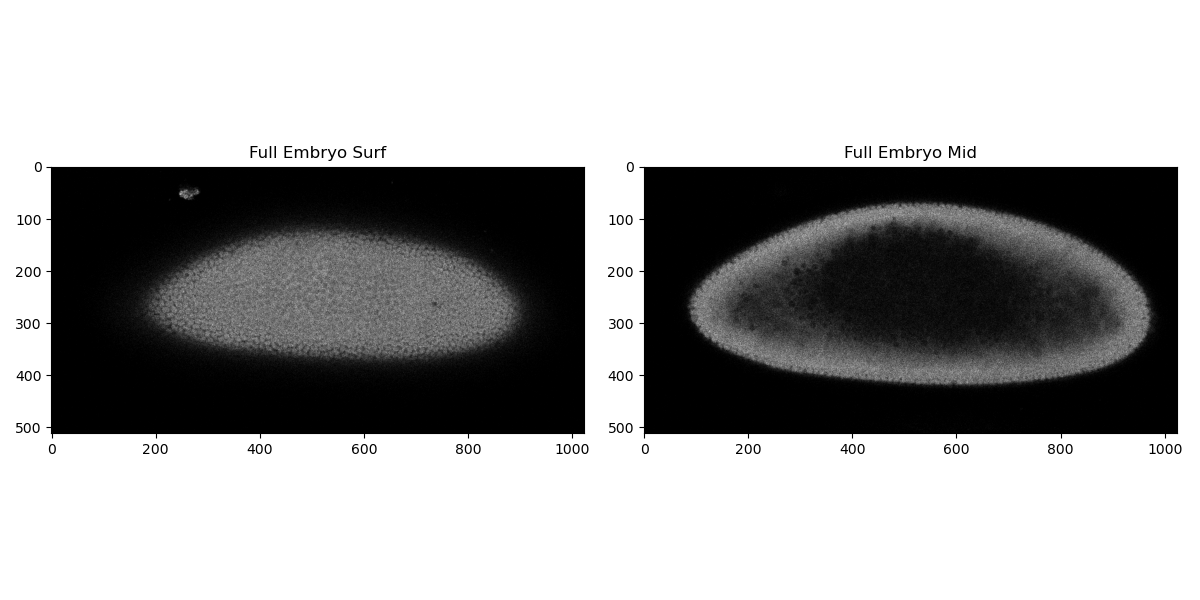

In [17]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(FullEmbryo_dataset.channels_full_dataset_surf[0][0, :, :], cmap='gray')
plt.title('Full Embryo Surf')

plt.subplot(1, 2, 2)
plt.imshow(FullEmbryo_dataset.channels_full_dataset_mid[0][0, :, :], cmap='gray')
plt.title('Full Embryo Mid')

plt.tight_layout()
plt.show()

In [18]:
fullEmbryo = fullEmbryo_pipeline.FullEmbryo(FullEmbryo_dataset, dataset, his_channel=0)

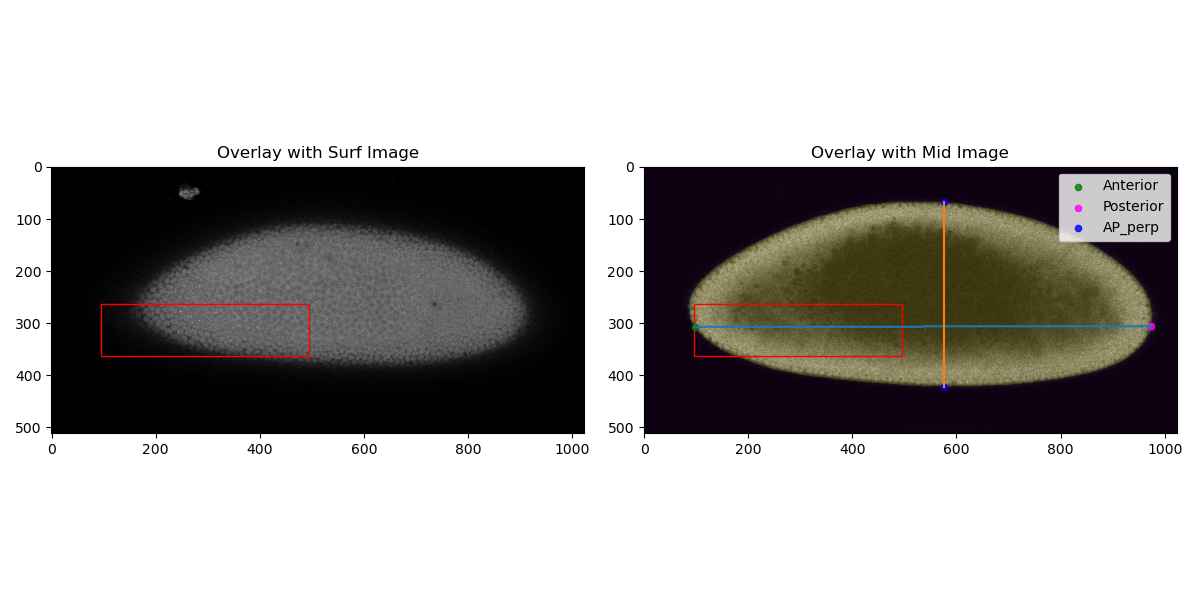

In [19]:
fullEmbryo.find_ap_axis(make_plots=True)

In [20]:
compiled_dataframe = fullEmbryo.xy_to_ap(compiled_dataframe)
compiled_dataframe.head()

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y,ap,ap90
0,1,"[246, 248, 259, 260, 261, 262, 263, 264, 265, ...","[1108.5390014648438, 1118.2740001678467, 1167....","[227.548125, 946.5786885245901, 1272.734368421...","[68.80497281940325, 81.88031901064626, 89.9716...","[245.72781775526312, 242.58327656186466, 247.6...","[14.156389561900546, 4.639520272131454, 5.0864...","[0.10716917640911858, 0.1057685656848908, 0.10...","[-0.10867276928639148, -0.11917425817428993, -..."
1,2,[482],[2175.17799949646],[114.10088023952095],[77.90116316555358],[366.1172398591699],[7.129296014004814],[0.16079185307696017],[-0.11642688910884005]
2,3,"[222, 413]","[1001.9560012817383, 1862.726999282837]","[99.75139490445859, 63.92335294117647]","[77.15865287667032, 73.38991771620272]","[477.2447759627555, 503.170037634059]","[13.210923449270307, 6.95294498892778]","[0.21028919124204706, 0.221836567247637]","[-0.10971605375036377, -0.11662148549067822]"
3,6,[467],[2103.4029998779297],[176.51811976047904],[73.58881264518519],[659.8866086046471],[4.392858713179112],[0.29163972658497206],[-0.11944643944961693]
4,7,"[399, 477]","[1800.466999053955, 2154.337999343872]","[114.69377914110429, 256.639652173913]","[80.31322288378298, 64.34699232246267]","[705.9982227776934, 706.1192629007876]","[5.229254322308828, 8.856716754317265]","[0.3121783099108346, 0.3122322224163611]","[-0.11852350997273477, -0.11452074863797966]"


## RateExtraction Analysis

### Fit and Average

In [21]:
from transcription_pipeline.RateExtraction import FitAndAverage

In [22]:
faadata = FitAndAverage(compiled_dataframe, nc14_start_frame, min_frames, num_bins, test_dataset_name)

Load previous particle trace fit checking results from "particle_fits_checked.pkl"


In [23]:
compiled_dataframe

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y,ap,ap90
0,1,"[246, 248, 259, 260, 261, 262, 263, 264, 265, ...","[1108.5390014648438, 1118.2740001678467, 1167....","[227.548125, 946.5786885245901, 1272.734368421...","[68.80497281940325, 81.88031901064626, 89.9716...","[245.72781775526312, 242.58327656186466, 247.6...","[14.156389561900546, 4.639520272131454, 5.0864...","[0.10716917640911858, 0.1057685656848908, 0.10...","[-0.10867276928639148, -0.11917425817428993, -..."
1,2,[482],[2175.17799949646],[114.10088023952095],[77.90116316555358],[366.1172398591699],[7.129296014004814],[0.16079185307696017],[-0.11642688910884005]
2,3,"[222, 413]","[1001.9560012817383, 1862.726999282837]","[99.75139490445859, 63.92335294117647]","[77.15865287667032, 73.38991771620272]","[477.2447759627555, 503.170037634059]","[13.210923449270307, 6.95294498892778]","[0.21028919124204706, 0.221836567247637]","[-0.10971605375036377, -0.11662148549067822]"
3,6,[467],[2103.4029998779297],[176.51811976047904],[73.58881264518519],[659.8866086046471],[4.392858713179112],[0.29163972658497206],[-0.11944643944961693]
4,7,"[399, 477]","[1800.466999053955, 2154.337999343872]","[114.69377914110429, 256.639652173913]","[80.31322288378298, 64.34699232246267]","[705.9982227776934, 706.1192629007876]","[5.229254322308828, 8.856716754317265]","[0.3121783099108346, 0.3122322224163611]","[-0.11852350997273477, -0.11452074863797966]"
...,...,...,...,...,...,...,...,...,...
417,1008,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.690999984741211, 5.940000534057617, 10.6110...","[430.84642690058485, 349.86855681818184, 561.1...","[69.48499812400206, 71.46994561963677, 70.1765...","[501.0174122858542, 501.9514315245448, 502.548...","[141.6726703939947, 142.58916725518282, 141.69...","[0.22087776595914707, 0.2212937876557594, 0.22...","[0.03203640359506839, 0.033047721635750836, 0...."
418,1014,[41],[184.33200073242188],[467.9494550898204],[72.57908322434675],[516.5779591798141],[128.40084342367038],[0.22780859227501263],[0.017391467407828445]
419,1044,[25],[112.73100090026855],[1213.1478372093025],[81.16483215114691],[82.65461924406534],[242.12681791757745],[0.03453471032280836],[0.14288358262444542]
420,1059,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[1.8999996185302734, 6.3600006103515625, 10.81...","[1084.8989171597634, 947.0559659090909, 1064.0...","[99.01171238630364, 89.90694362681887, 88.1441...","[78.34983616594018, 78.92418904120115, 79.0202...","[245.47685825666815, 245.49776747353718, 244.1...","[0.032617316027782416, 0.032873138657255475, 0...","[0.14658021965116105, 0.14660329214505788, 0.1..."


In [24]:
faadata.compiled_dataframe_fits

,index,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y,ap,ap90,fit_results,modified_fit_results,tv_denoised_trace,approval_status
0,0,264,"[389, 390, 392, 396, 397, 398, 399, 400, 401, ...","[1758.3759994506836, 1762.8359985351562, 1771....","[313.87132499999996, 191.38240000000002, 312.6...","[68.20192793000338, 69.42050297338223, 71.8261...","[4.861477877552322, 4.585785817687983, 4.58059...","[209.3999649222209, 209.19933824419215, 210.20...","[0.16861947610977385, 0.16849726008873347, 0.1...","[0.0768519019148244, 0.07664701987712257, 0.07...","[[1758.3759994506836, 1762.8359985351562, 1771...",None,"[379.1359535259411, 382.3301433709688, 389.931...",-1
1,1,237,"[272, 273, 274, 275, 276, 277, 280, 281, 283, ...","[1225.5630016326904, 1230.0069999694824, 1234....","[984.1380056179776, 1170.9144463276837, 1040.0...","[80.8951490674914, 82.13652538123905, 81.12996...","[4.76094110750893, 5.026868620328596, 5.803815...","[149.23765088690558, 149.49659725274205, 150.6...","[0.16777323055730806, 0.16789199076559844, 0.1...","[0.012704420763270418, 0.012971809163155545, 0...","[[1225.5630016326904, 1230.0069999694824, 1234...",None,"[1088.7157864168703, 1088.9312473599539, 1092....",-1
2,2,232,"[283, 284, 285, 287, 295, 296, 297, 298, 299, ...","[1279.5639991760254, 1284.0240001678467, 1288....","[737.359320754717, 761.3095254237288, 798.6589...","[81.86741662742298, 74.80938418336872, 78.8934...","[4.9112910348166965, 4.953181313466609, 4.5772...","[104.33893379253654, 103.7856091345088, 103.26...","[0.16723940749000935, 0.167250188848699, 0.167...","[-0.03517579337456591, -0.03576717511850634, -...","[[1279.5639991760254, 1284.0240001678467, 1288...",None,"[686.7895983927536, 689.0509999279227, 689.608...",-1
3,3,269,"[253, 267, 337, 338, 339, 340, 341, 344, 350, ...","[1142.4320011138916, 1204.7540016174316, 1521....","[1182.6903258426967, 1097.0397592592594, 339.9...","[80.53124125017038, 76.62233876265583, 66.6200...","[8.954795249179984, 8.452676858985955, 14.8130...","[242.02752232140054, 239.60361073384587, 232.6...","[0.17082962722936107, 0.17057957146836136, 0.1...","[0.1115082079825522, 0.1089400770159786, 0.101...","[[1142.4320011138916, 1204.7540016174316, 1521...",None,"[771.1228550813227, 732.6624223318827, 580.346...",-1
4,4,273,"[292, 293, 294, 372, 376, 377, 378, 379, 380, ...","[1321.2040004730225, 1325.6639995574951, 1330....","[975.1949599999999, 970.9680952380953, 782.61,...","[82.5230085911878, 83.4884700489132, 83.770912...","[12.00500243527985, 11.396786643287797, 12.044...","[7.0872726891463165, 7.719339653011374, 7.7072...","[0.1690177434318643, 0.16876245532385062, 0.16...","[-0.13910749961675584, -0.1384135747204478, -0...","[None, None, None, None, None]",None,"[724.7975724394853, 721.6070816337785, 712.894...",-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,112,82,"[259, 260, 261, 262, 263, 264, 265, 266, 267, ...","[1166.2119998931885, 1170.8719997406006, 1175....","[223.70284239130436, 215.45711392405065, 50.33...","[61.55095760177212, 72.55062226564422, 70.2942...","[663.0372655384625, 663.2514323029843, 663.495...","[215.9031408158372, 216.18990423960668, 214.97...","[0.4540895673667542, 0.45418625536780416, 0.45...","[0.06219206465945125, 0.062490812473954514, 0....","[[1166.2119998931885, 1170.8719997406006, 1175...",None,"[297.1049690799018, 299.3291685850976, 304.094...",1
113,113,60,"[289, 290, 291, 292, 293, 297, 300, 301, 302, ...","[1305.0750007629395, 1309.534999847412, 1313.7...","[172.86054736842104, 174.04739024390244, 15.83...","[68.93201425500081, 71.7060296290224, 75.71719...","[735.6801611254681, 735.3944627115615, 736.261...","[145.73757317807645, 145.7551074825704, 148.22...","[0.4846512290640314, 0.48452758489948533, 0.48...","[-0.015008481682667644, -0.014980411438019226,...","[[1305.0750007629395, 1309.534999847412, 1313....",None,"[219.59925584105287, 220.1964290677086, 221.39...",-1
114,114,75,"[274, 280, 282, 283

/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/RateExtraction.py:556: UserWarning: No particle has been left unchecked
  warn('No particle has been left unchecked')


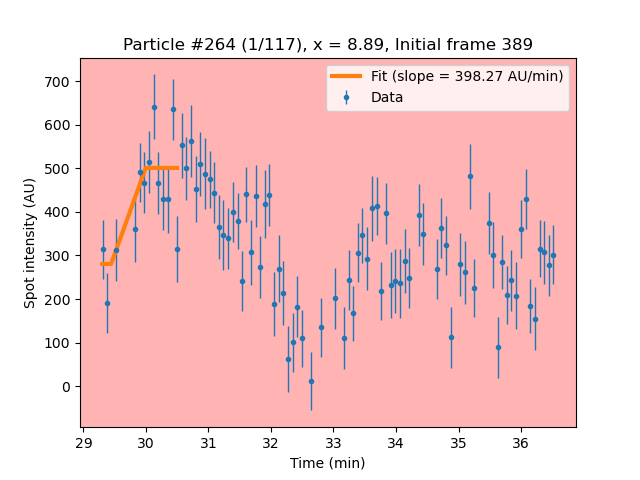

In [25]:
faadata.check_particle_fits()

In [26]:
faadata.save_checked_particle_fits()

No changes made to the particle fit checking results


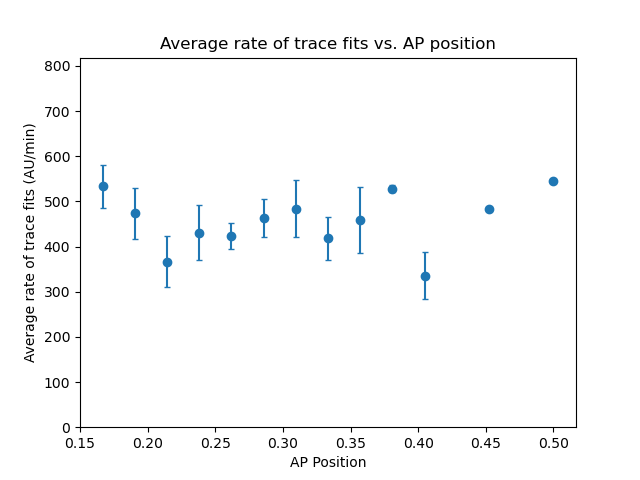

In [27]:
faax, faay, faay_err, _, _ = faadata.average_particle_fits();

### Average and Fit (only on traces used in "Fit and Average")

To run this cell, you need to first save the data from "Fit and Average" (i.e. first run `faadata.save_checked_particle_fits()`)

In [28]:
import pandas as pd

faadatapoints = pd.read_pickle(faadata.checked_particle_fits_file_path)

In [29]:
from transcription_pipeline.RateExtraction import AverageAndFit
time_bin_width = dataset.export_frame_metadata[0]['t_s'][1, 0]
aafdata_sp = AverageAndFit(faadatapoints, nc14_start_frame-3, time_bin_width, num_bins, test_dataset_name)

No previous bin fit checking results detected. Do bin fitting for the dataframe.


/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/RateExtraction.py:1023: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.bin_average_fit_dataframe['bin_particle_number'][bin] = bin_particle_num[bin]
/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/RateExtraction.py:1043: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.bin_average_fit_dataframe['approval_status'][bin] = -1
/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/RateExtraction.py:1023: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

Failed to fit average trace 17: Each lower bound must be strictly less than each upper bound.


/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/RateExtraction.py:1038: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.bin_average_fit_dataframe['bin_fit_result'][bin] = bin_fit_result
/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/RateExtraction.py:1039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.bin_average_fit_dataframe['bin_fit_slope'][bin] = bin_fit_result[4][3]
/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/RateExtraction.py:1023: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

In [92]:
dataframe_nc14

,index,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y,ap,ap90,fit_results,modified_fit_results,tv_denoised_trace,approval_status
0,0,264,"[389, 390, 392, 396, 397, 398, 399, 400, 401, ...","[1758.3759994506836, 1762.8359985351562, 1771....","[313.87132499999996, 191.38240000000002, 312.6...","[68.20192793000338, 69.42050297338223, 71.8261...","[4.861477877552322, 4.585785817687983, 4.58059...","[209.3999649222209, 209.19933824419215, 210.20...","[0.16861947610977385, 0.16849726008873347, 0.1...","[0.0768519019148244, 0.07664701987712257, 0.07...","[[1758.3759994506836, 1762.8359985351562, 1771...",None,"[379.1359535259411, 382.3301433709688, 389.931...",-1
1,1,237,"[272, 273, 274, 275, 276, 277, 280, 281, 283, ...","[1225.5630016326904, 1230.0069999694824, 1234....","[984.1380056179776, 1170.9144463276837, 1040.0...","[80.8951490674914, 82.13652538123905, 81.12996...","[4.76094110750893, 5.026868620328596, 5.803815...","[149.23765088690558, 149.49659725274205, 150.6...","[0.16777323055730806, 0.16789199076559844, 0.1...","[0.012704420763270418, 0.012971809163155545, 0...","[[1225.5630016326904, 1230.0069999694824, 1234...",None,"[1088.7157864168703, 1088.9312473599539, 1092....",-1
2,2,232,"[283, 284, 285, 287, 295, 296, 297, 298, 299, ...","[1279.5639991760254, 1284.0240001678467, 1288....","[737.359320754717, 761.3095254237288, 798.6589...","[81.86741662742298, 74.80938418336872, 78.8934...","[4.9112910348166965, 4.953181313466609, 4.5772...","[104.33893379253654, 103.7856091345088, 103.26...","[0.16723940749000935, 0.167250188848699, 0.167...","[-0.03517579337456591, -0.03576717511850634, -...","[[1279.5639991760254, 1284.0240001678467, 1288...",None,"[686.7895983927536, 689.0509999279227, 689.608...",-1
3,3,269,"[253, 267, 337, 338, 339, 340, 341, 344, 350, ...","[1142.4320011138916, 1204.7540016174316, 1521....","[1182.6903258426967, 1097.0397592592594, 339.9...","[80.53124125017038, 76.62233876265583, 66.6200...","[8.954795249179984, 8.452676858985955, 14.8130...","[242.02752232140054, 239.60361073384587, 232.6...","[0.17082962722936107, 0.17057957146836136, 0.1...","[0.1115082079825522, 0.1089400770159786, 0.101...","[[1142.4320011138916, 1204.7540016174316, 1521...",None,"[771.1228550813227, 732.6624223318827, 580.346...",-1
4,4,273,"[292, 293, 294, 372, 376, 377, 378, 379, 380, ...","[1321.2040004730225, 1325.6639995574951, 1330....","[975.1949599999999, 970.9680952380953, 782.61,...","[82.5230085911878, 83.4884700489132, 83.770912...","[12.00500243527985, 11.396786643287797, 12.044...","[7.0872726891463165, 7.719339653011374, 7.7072...","[0.1690177434318643, 0.16876245532385062, 0.16...","[-0.13910749961675584, -0.1384135747204478, -0...","[None, None, None, None, None]",None,"[724.7975724394853, 721.6070816337785, 712.894...",-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,112,82,"[259, 260, 261, 262, 263, 264, 265, 266, 267, ...","[1166.2119998931885, 1170.8719997406006, 1175....","[223.70284239130436, 215.45711392405065, 50.33...","[61.55095760177212, 72.55062226564422, 70.2942...","[663.0372655384625, 663.2514323029843, 663.495...","[215.9031408158372, 216.18990423960668, 214.97...","[0.4540895673667542, 0.45418625536780416, 0.45...","[0.06219206465945125, 0.062490812473954514, 0....","[[1166.2119998931885, 1170.8719997406006, 1175...",None,"[297.1049690799018, 299.3291685850976, 304.094...",1
113,113,60,"[289, 290, 291, 292, 293, 297, 300, 301, 302, ...","[1305.0750007629395, 1309.534999847412, 1313.7...","[172.86054736842104, 174.04739024390244, 15.83...","[68.93201425500081, 71.7060296290224, 75.71719...","[735.6801611254681, 735.3944627115615, 736.261...","[145.73757317807645, 145.7551074825704, 148.22...","[0.4846512290640314, 0.48452758489948533, 0.48...","[-0.015008481682667644, -0.014980411438019226,...","[[1305.0750007629395, 1309.534999847412, 1313....",None,"[219.59925584105287, 220.1964290677086, 221.39...",-1
114,114,75,"[274, 280, 282, 283

In [83]:
faadatapoints[25:35]

,index,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y,ap,ap90,fit_results,modified_fit_results,tv_denoised_trace,approval_status
25,25,217,"[210, 211, 212, 213, 214, 215, 216, 217, 218, ...","[947.7760009765625, 952.44700050354, 956.69600...","[215.20667415730335, 207.12543575418994, 235.6...","[65.53435119124794, 74.20329760558862, 63.2686...","[153.82657807135985, 152.84851247701275, 152.1...","[92.91899646066624, 92.59284019720052, 92.8853...","[0.23165633446720957, 0.2312278963395148, 0.23...","[-0.05223858989610918, -0.052554279284474585, ...","[[947.7760009765625, 952.44700050354, 956.6960...",None,"[322.64621688834103, 325.45333103629616, 331.7...",1
26,26,121,"[209, 211, 212, 213, 214, 215, 216, 217, 218, ...","[943.3229999542236, 952.6560001373291, 957.336...","[288.127421965318, 158.14082558139535, 180.452...","[71.01585233244798, 65.84735048841247, 67.3091...","[154.36545263429963, 153.61335252819308, 153.5...","[40.685864783742794, 26.12517433837021, 26.560...","[0.23119312288899657, 0.23067275335682383, 0.2...","[-0.10795220137964595, -0.12345351830237171, -...","[[943.3229999542236, 952.6560001373291, 957.33...",None,"[326.0609698111166, 329.67383732363606, 338.16...",1
27,27,222,"[163, 188, 189, 190, 191, 192, 193, 194, 195, ...","[732.7430000305176, 850.6870002746582, 855.147...","[266.5964198895027, 89.57226373626375, 93.0993...","[82.12296121114507, 67.17569297289461, 74.1382...","[166.76630146885623, 173.91808954561395, 173.1...","[172.4792697251281, 178.9375240960163, 179.471...","[0.2383284154172159, 0.24151557487868686, 0.24...","[0.03217159791756, 0.03882335921797699, 0.0394...","[[732.7430000305176, 850.6870002746582, 855.14...",None,"[211.30273684083306, 215.237619654919, 224.109...",1
28,28,227,"[186, 188, 189, 190, 191, 192, 193, 194, 195, ...","[835.5879993438721, 850.4670009613037, 855.147...","[34.76402857142857, 283.96431818181816, 157.90...","[62.311499818507315, 67.58975841853076, 62.750...","[182.7628750722517, 182.3164156653682, 183.404...","[239.05529206759115, 239.22631495967968, 238.2...","[0.24615270990158486, 0.24596140794554364, 0.2...","[0.10263645036820614, 0.10283345915938456, 0.1...","[[835.5879993438721, 850.4670009613037, 855.14...",None,"[303.57270188655247, 309.2719178645441, 320.67...",1
29,29,235,"[210, 213, 214, 215, 216, 217, 218, 219, 220, ...","[948.4070014953613, 962.0069999694824, 966.676...","[262.161, 106.07809696969697, 193.860700636942...","[65.67787358768553, 69.773064858856, 68.994603...","[171.25458991386714, 171.70666409444857, 172.1...","[149.26689229723672, 146.33982205806137, 146.3...","[0.23996483875785368, 0.2401218055716714, 0.24...","[0.00727309737646932, 0.004137144633523503, 0....","[[948.4070014953613, 962.0069999694824, 966.67...",None,"[318.55289849079986, 323.59141186097014, 336.0...",1
30,30,177,"[214, 215, 216, 217, 218, 219, 220, 221, 222, ...","[966.6760005950928, 971.1360015869141, 975.815...","[98.12088, 85.36682758620688, 39.7037324840764...","[69.97671774077817, 66.01265053356747, 74.5940...","[171.06301633568762, 170.44451502978387, 171.1...","[63.03584284611022, 64.19447700386928, 62.3768...","[0.23873132490542487, 0.2384786021998379, 0.23...","[-0.08466836134927569, -0.08341262298471981, -...","[[966.6760005950928, 971.1360015869141, 975.81...",None,"[148.46851279916893, 149.858182811014, 152.782...",1
31,31,206,"[208, 209, 210, 211, 212, 213, 214, 215, 216, ...","[939.0670013427734, 943.7390003204346, 948.196...","[173.0717741935484, 177.7855677419355, 265.043...","[73.82151793650132, 67.43936718165327, 65.9783...","[171.54515221029087, 171.2392234690435, 170.38...","[115.61624656612139, 116.33017218711959, 114.8...","[0.2396418771002494, 0.23951875199422418, 0.23...","[-0.02861795380615169, -0.027846661186074866, ...","[[939.0670013427734, 943.7390003204346, 948.19...",None,"[279.15887501876216, 282.0179841851814, 288.30...",1
32,32,252,"[290, 291, 301, 302, 303, 305, 306, 307, 308, ...","[1310.3

Moved to bin 7 out of 42, the first unchecked bin


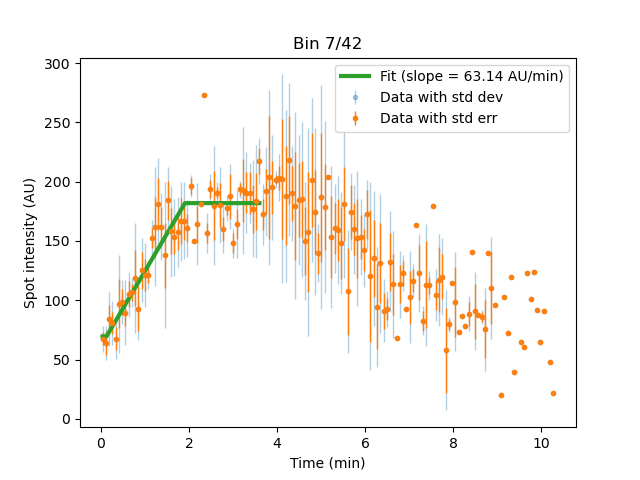

In [35]:
aafdata_sp.check_bin_fits()

In [36]:
aafdata_sp.bin_average_fit_dataframe;

In [37]:
aafdata_sp.save_checked_bin_fits()

Checked bin fits saved


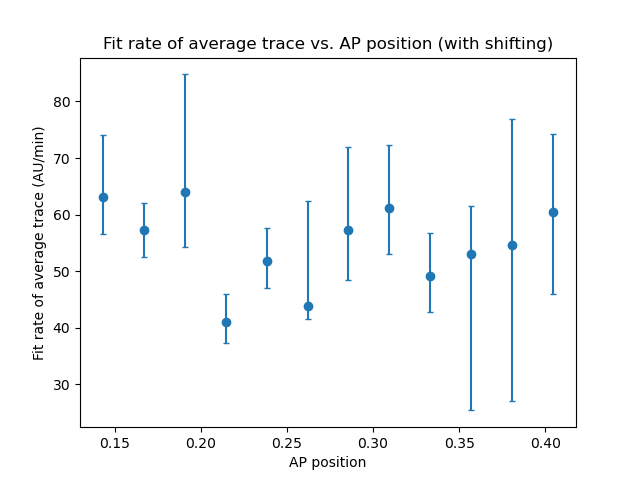

In [38]:
aafspx, aafspy, aafspy_err = aafdata_sp.plot_bin_fits()

### Average and Fit (Original)

Remember to rename the file `bin_fits_checked.pkl` so that the operations below won't use its result.

In [30]:
from transcription_pipeline.RateExtraction import AverageAndFit

In [31]:
time_bin_width = dataset.export_frame_metadata[0]['t_s'][1, 0]
aafdata = AverageAndFit(compiled_dataframe, nc14_start_frame, time_bin_width, num_bins, test_dataset_name)

No previous bin fit checking results detected. Do bin fitting for the dataframe.


/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/RateExtraction.py:1023: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.bin_average_fit_dataframe['bin_particle_number'][bin] = bin_particle_num[bin]
/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/RateExtraction.py:1027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.bin_average_fit_dataframe['time_bin_centers'][bin] = time_bin_centers
/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/RateExtraction.py:1028: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

Failed to find derivative sign change for average trace 18
Failed to fit average trace 18: local variable 't_interp' referenced before assignment
Failed to find derivative sign change for average trace 19
Failed to fit average trace 19: local variable 't_interp' referenced before assignment


/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/RateExtraction.py:1038: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.bin_average_fit_dataframe['bin_fit_result'][bin] = bin_fit_result
/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/RateExtraction.py:1039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.bin_average_fit_dataframe['bin_fit_slope'][bin] = bin_fit_result[4][3]
/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/RateExtraction.py:1023: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

Moved to bin 7 out of 42, the first unchecked bin


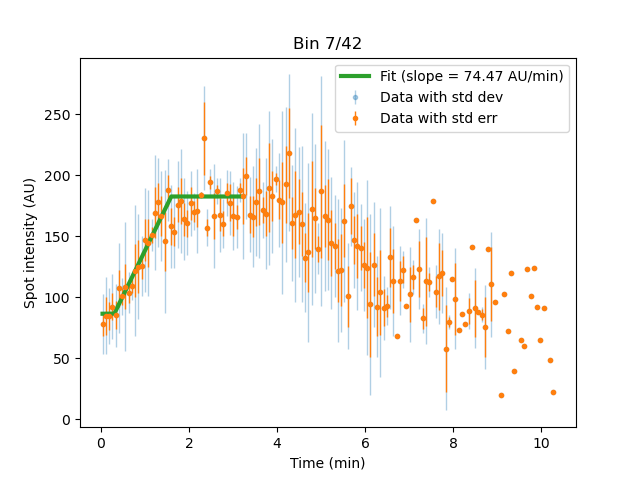

In [191]:
aafdata.check_bin_fits()

In [193]:
aafdata.bin_average_fit_dataframe

,time_bin_centers,time_bin_means,time_bin_stddevs,time_bin_stderrs,denoised_time_bin_means,bin_fit_result,bin_fit_slope,bin_fit_result_modified,bin_fit_slope_modified,bin_particle_number,approval_status
0,None,None,None,None,None,None,NaN,None,NaN,0,-1
1,None,None,None,None,None,None,NaN,None,NaN,0,-1
2,None,None,None,None,None,None,NaN,None,NaN,0,-1
3,None,None,None,None,None,None,NaN,None,NaN,0,-1
4,None,None,None,None,None,None,NaN,None,NaN,0,-1
5,None,None,None,None,None,None,NaN,None,NaN,0,-1
6,"[0.037116654713948566, 0.1113499641418457, 0.1...","[77.77398044905473, 84.65395397534031, 84.3782...","[24.49793505218771, 31.666523374538322, 22.810...","[10.00124010495038, 15.833261687269161, 11.405...","[114.8619050568798, 115.10015230773826, 115.58...","[[0.037116654713948566, 0.1113499641418457, 0....",74.466752,None,NaN,6,1
7,"[0.037116654713948566, 0.1113499641418457, 0.1...","[65.96782156556377, 63.95788971831487, 69.5448...","[27.712734332382936, 32.07727107243704, 40.969...","[6.531954123883075, 9.671661131435895, 13.6565...","[87.8323838114404, 88.07514234200306, 88.56935...","[[0.037116654713948566, 0.1113499641418457, 0....",47.809970,None,NaN,16,1
8,"[0.037116654713948566, 0.1113499641418457, 0.1...","[65.37488487243616, 70.37409666753474, 75.7296...","[25.743319644090516, 28.96989067808039, 18.009...","[5.61765290040421, 10.242403074351795, 6.00302...","[92.2519298819578, 92.41141194101532, 92.73584...","[[0.037116654713948566, 0.1113499641418457, 0....",49.487809,None,NaN,18,1
9,"[0.037116654713948566, 0.1113499641418457, 0.1...","[53.78366013348968, 84.11950096304001, 61.4647...","[21.210677937227143, 18.818167860510084, 18.21...","[4.522131730604968, 7.11259889839687, 6.440398...","[87.38859721476487, 87.60747455794981, 88.0444...","[[0.037116654713948566, 0.1113499641418457, 0....",42.841521,None,NaN,19,1


In [194]:
aafdata.save_checked_bin_fits()

Checked bin fits saved


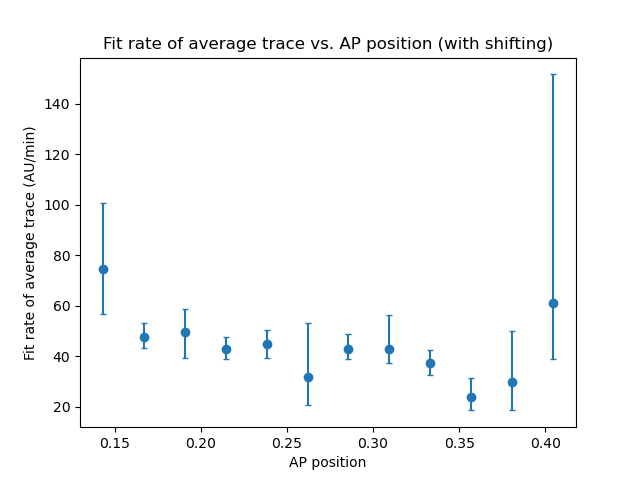

In [195]:
aafx, aafy, aafy_err = aafdata.plot_bin_fits()

In [200]:
aafy[aaf_mask].shape

(12,)

### Overlaying the three methods

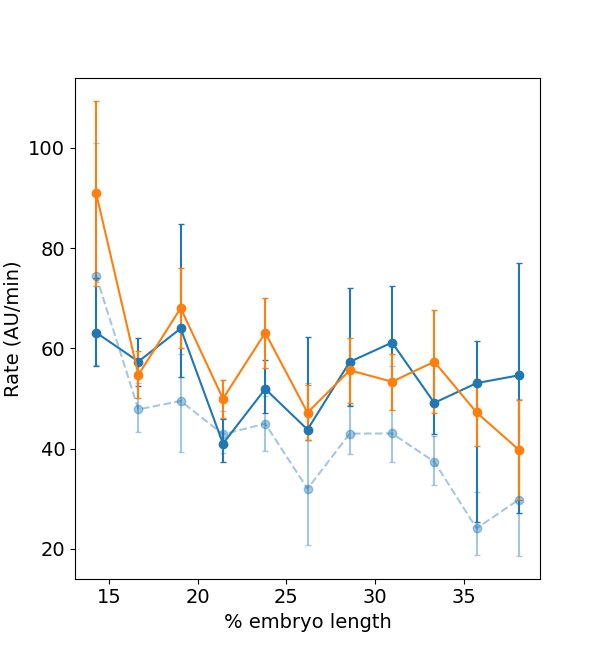

(0.0, 120.0)

In [241]:
aafsp_mask = ~np.isnan(aafspy)
aaf_mask = ~np.isnan(aafy)
faa_mask = ~np.isnan(faay)
start_bin = 0
end_bin = -1

plt.close('all')
plt.figure(figsize=(6,6.5))

plt.errorbar(100*aafx[aaf_mask][start_bin:end_bin-1], aafy[aaf_mask][start_bin:end_bin-1], yerr=aafy_err[:,aaf_mask][:,start_bin:end_bin-1], capsize=2, fmt='o--', color='C0', alpha=.4, label=r'Average $\rightarrow$ fit (all traces)')
#plt.errorbar(aafx[aaf_mask][start_bin:end_bin-1], aafy[aaf_mask][start_bin:end_bin-1], yerr=aafy_err[:,aaf_mask][:,start_bin:end_bin-1], capsize=2, fmt='o--', color='C0', label='Method 1')
plt.errorbar(100*aafspx[aafsp_mask][start_bin:end_bin], aafspy[aafsp_mask][start_bin:end_bin], yerr=aafspy_err[:,aafsp_mask][:,start_bin:end_bin], capsize=2, fmt='o-', color='C0', label=r'Average $\rightarrow$ fit (curated traces)')
plt.errorbar(100*faax[faa_mask][start_bin:end_bin], faay[faa_mask][start_bin:end_bin], yerr=faay_err[faa_mask][start_bin:end_bin], capsize=2, fmt='o-', color='C1', label=r'Fit $\rightarrow$ average (curated traces)')



plt.xlabel('% embryo length', fontsize=14)
plt.ylabel('Rate (AU/min)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('Rate vs. AP position')
plt.show()
plt.legend(fontsize=12)
plt.ylim(0,120)

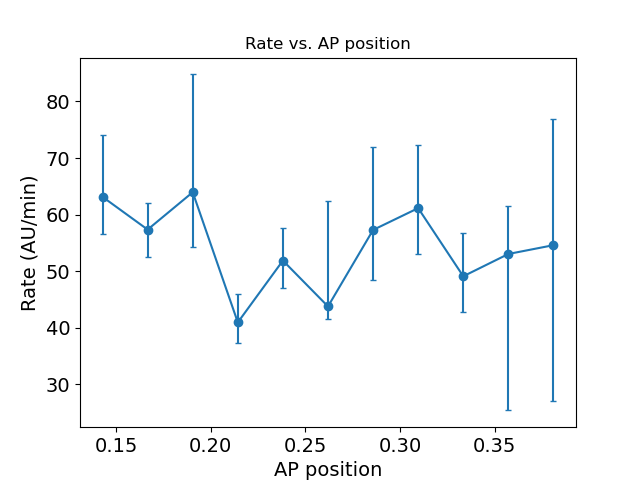

(0.0, 120.0)

In [198]:
faa_mask = ~np.isnan(faay)
aaf_mask = ~np.isnan(aafspy)
start_bin = 0
end_bin = -1

plt.close('all')
plt.figure()
plt.errorbar(aafspx[aaf_mask][start_bin:end_bin], aafspy[aaf_mask][start_bin:end_bin], yerr=aafspy_err[:,aaf_mask][:,start_bin:end_bin], capsize=2, fmt='o-', label='method 1')
#plt.errorbar(faax[faa_mask][start_bin:end_bin], faay[faa_mask][start_bin:end_bin], yerr=faay_err[faa_mask][start_bin:end_bin], capsize=2, fmt='o-', label='method 2')
#plt.errorbar(aafx, aafy, yerr=aafy_err, capsize=2, fmt='o', label='aaf')
plt.xlabel('AP position', fontsize=14)
plt.ylabel('Rate (AU/min)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Rate vs. AP position')
plt.show()
plt.legend(fontsize=12)
plt.ylim(0,120)